In [1]:
%load_ext autotime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

time: 1.27 s (started: 2022-10-13 16:49:03 +08:00)


In [2]:
# from previous notebook, we have saved all the financial ratios and its corresponding annual returns
# total of 29,650 rows
x = pickle.load(open('./data/03_finratios.pkl', 'rb'))
y = pickle.load(open('./data/03_returns.pkl', 'rb'))

time: 0 ns (started: 2022-10-13 16:49:04 +08:00)


In [3]:
# view the x dataframe containing the financial ratios
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29650 entries, 0 to 29649
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CR             29650 non-null  float64
 1   Acid           29650 non-null  float64
 2   CashRatio      29650 non-null  float64
 3   InvTO          29650 non-null  float64
 4   AssetTurnover  29650 non-null  float64
 5   NWC_TO         29650 non-null  float64
 6   PM             29650 non-null  float64
 7   GPM            29650 non-null  float64
 8   ROE            29650 non-null  float64
 9   ROCE           29650 non-null  float64
 10  PE             29650 non-null  float64
 11  PB             29650 non-null  float64
 12  PS             29650 non-null  float64
 13  EV_EBIT        29650 non-null  float64
 14  DE             29650 non-null  float64
 15  DebtRatio      29650 non-null  float64
 16  ICR            29650 non-null  float64
 17  Equity_Liab    29650 non-null  float64
 18  Workin

In [4]:
y

,Ticker,Returns
0,A,0.563351
1,A,0.535595
2,A,0.198018
3,A,0.076426
4,A,-0.050044
...,...,...
29645,ZYXI,0.772254
29646,ZYXI,0.701262
29647,ZYXI,0.400618
29648,ZYXI,-0.325537


time: 15 ms (started: 2022-10-13 16:49:04 +08:00)


In [5]:
# Store the target returns temporarily
returns = y['Returns']
returns = returns.astype('float64')
returns

0        0.563351
1        0.535595
2        0.198018
3        0.076426
4       -0.050044
           ...   
29645    0.772254
29646    0.701262
29647    0.400618
29648   -0.325537
29649   -0.319614
Name: Returns, Length: 29650, dtype: float64

time: 0 ns (started: 2022-10-13 16:49:04 +08:00)


In [6]:
# Add the Returns column from y to the x dataframe
x['Returns'] = returns

# Drop the null rows (if any) and reset index
x = x.dropna(axis=0)
x = x.reset_index(drop=True)

# Randomise the rows for train-test-split
# Specify frac=1 because we want all the rows back
x = x.sample(frac=1, random_state=42)

time: 16 ms (started: 2022-10-13 16:49:04 +08:00)


After randomizing the rows in the x dataframe (with the targets), we want to split back dataset into x and y

In [7]:
# There should still be 29650 rows, but this time the "Returns" column is inside as the target variable.
x

,CR,Acid,CashRatio,InvTO,AssetTurnover,NWC_TO,PM,GPM,ROE,ROCE,...,DE,DebtRatio,ICR,Equity_Liab,WorkingCap,OI_NWCFA,WC_TA,RE_TA,EBIT_TA,Returns
25628,1.605372,1.605372,0.011801,0.0,1.334186,2.638366,0.143161,0.455618,0.052645,0.010073,...,2.788468,1.358620,2.708548,0.358620,1.605372,0.215433,0.036790,1.218756,0.009461,-0.206629
7249,1.498312,0.711767,0.423275,0.0,1.788779,1.850493,0.000000,0.090585,-0.019255,-0.020809,...,1.176810,1.849755,-45.656325,0.849755,1.498312,-0.154405,0.245963,-0.014983,-0.010538,3.016790
9043,1.797912,1.349417,0.479910,0.0,2.919091,1.052978,0.018086,0.349227,0.010122,-0.000597,...,1.886285,1.530143,2.834975,0.530143,1.797912,0.057048,0.184143,0.802735,-0.000459,-0.053788
8164,0.456019,0.317251,0.180810,0.0,0.851384,0.000000,0.063993,0.226507,0.058905,0.036372,...,1.518104,1.658716,14.800000,0.658716,0.456019,0.108339,-0.132513,0.105833,0.027512,0.015873
26082,1.118243,0.849810,0.223240,0.0,2.330795,5.000000,0.107215,0.468250,0.266111,0.058303,...,6.574310,1.152107,8.726368,0.152107,1.118243,0.288867,0.035133,0.000000,0.040979,1.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,1.923444,1.869230,0.092680,0.0,1.923501,1.798922,0.045816,0.130264,0.029919,0.007506,...,0.707267,2.413892,16.459255,1.413892,1.923444,0.039919,0.212625,0.338118,0.005778,-0.236701
5390,1.291864,1.291864,0.928858,0.0,0.567539,4.742500,0.271745,0.775171,0.227493,0.088717,...,2.743601,1.364484,14.298969,0.364484,1.291864,0.185304,0.047153,0.264116,0.074384,0.182829
860,0.020949,0.020949,0.000762,0.0,2000.000000,0.000000,0.000000,1.000000,0.134454,0.134454,...,0.000000,0.020949,600.000000,-0.979051,0.020949,0.172615,-1.500000,0.000000,-2.000000,-0.850000
15795,0.803855,0.803855,0.695407,0.0,0.035870,0.000000,0.237310,0.768409,0.016300,0.003655,...,1.060456,1.942990,2.726626,0.942990,0.803855,0.012942,-0.006632,0.000000,0.003531,0.633980


time: 16 ms (started: 2022-10-13 16:49:04 +08:00)


In [8]:
# Split properly into X and y again
y = x['Returns']
X = x.drop(columns='Returns')

time: 0 ns (started: 2022-10-13 16:49:04 +08:00)


In [9]:
y.head()

25628   -0.206629
7249     3.016790
9043    -0.053788
8164     0.015873
26082    1.181818
Name: Returns, dtype: float64

time: 16 ms (started: 2022-10-13 16:49:04 +08:00)


In [10]:
X.head()

,CR,Acid,CashRatio,InvTO,AssetTurnover,NWC_TO,PM,GPM,ROE,ROCE,...,EV_EBIT,DE,DebtRatio,ICR,Equity_Liab,WorkingCap,OI_NWCFA,WC_TA,RE_TA,EBIT_TA
25628,1.605372,1.605372,0.011801,0.0,1.334186,2.638366,0.143161,0.455618,0.052645,0.010073,...,118.480014,2.788468,1.358620,2.708548,0.358620,1.605372,0.215433,0.036790,1.218756,0.009461
7249,1.498312,0.711767,0.423275,0.0,1.788779,1.850493,0.000000,0.090585,-0.019255,-0.020809,...,-26.891326,1.176810,1.849755,-45.656325,0.849755,1.498312,-0.154405,0.245963,-0.014983,-0.010538
9043,1.797912,1.349417,0.479910,0.0,2.919091,1.052978,0.018086,0.349227,0.010122,-0.000597,...,-500.000000,1.886285,1.530143,2.834975,0.530143,1.797912,0.057048,0.184143,0.802735,-0.000459
8164,0.456019,0.317251,0.180810,0.0,0.851384,0.000000,0.063993,0.226507,0.058905,0.036372,...,80.914183,1.518104,1.658716,14.800000,0.658716,0.456019,0.108339,-0.132513,0.105833,0.027512
26082,1.118243,0.849810,0.223240,0.0,2.330795,5.000000,0.107215,0.468250,0.266111,0.058303,...,44.045819,6.574310,1.152107,8.726368,0.152107,1.118243,0.288867,0.035133,0.000000,0.040979


time: 0 ns (started: 2022-10-13 16:49:04 +08:00)


In [11]:
# Just checking on the baseline annual returns
y.mean()

0.26660093623808423

time: 0 ns (started: 2022-10-13 16:49:04 +08:00)


## Hyperparameter Tuning of the Random Forest Regressor

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

time: 0 ns (started: 2022-10-13 16:49:04 +08:00)


In [13]:
rf = RandomForestRegressor(n_jobs=-1)

time: 0 ns (started: 2022-10-13 16:49:04 +08:00)


In [14]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

time: 9.08 s (started: 2022-10-13 16:49:04 +08:00)


In [15]:
mse_train_cv = cross_val_score(rf, X_train, y_train, n_jobs=-1,
                         scoring="neg_mean_squared_error", cv=5)

time: 34.6 s (started: 2022-10-13 16:49:14 +08:00)


In [18]:
mse_train_cv

array([-2.03472016, -1.14921985, -1.17053275, -1.98556319, -1.21240169])

time: 16 ms (started: 2022-10-13 16:53:15 +08:00)


In [23]:
# Getting the mean RMSE and std dev. from doing 10 cross-validation runs
rmse_train_cv = np.sqrt(-mse_train_cv)

print(f"Train CV RMSE: {rmse_train_cv.mean()}")
print(f"Train CV RMSE Std Dev: {rmse_train_cv.std()}")

Train CV RMSE: 1.2181111563692262
Train CV RMSE Std Dev: 0.1633791209079569
time: 0 ns (started: 2022-10-13 16:58:06 +08:00)


In [24]:
y_pred = rf.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
pct_diff = round((rmse_test/rmse_train_cv.mean() - 1)*100,3)

print(f"RMSE of train CV: {rmse_train_cv.mean()}")
print(f"RMSE of test: {rmse_test}")
print(f"Generalization: {pct_diff}%")

RMSE of train CV: 1.2181111563692262
RMSE of test: 1.31597896712547
Generalization: 8.034%
time: 62 ms (started: 2022-10-13 16:58:30 +08:00)


In [25]:
# Use GridSearch to find what are the best hyperparameters to use

# Define the param grid
param_grid = {'bootstrap': [True, False],
              'n_estimators': [5, 10, 15],
              'max_features': [2, 3, 4], 
              'max_depth': [5, 10, 15],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [5, 7, 10]
             }

time: 0 ns (started: 2022-10-13 16:59:26 +08:00)


In [26]:
# Run the GridSearch
grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

time: 0 ns (started: 2022-10-13 16:59:30 +08:00)


In [27]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 10, 15],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [5, 7, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [5, 10, 15]},
             return_train_score=True, scoring='neg_mean_squared_error')

time: 10min 1s (started: 2022-10-13 16:59:32 +08:00)


In [28]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=15, max_features=3,
                      min_samples_leaf=5, min_samples_split=10, n_estimators=15,
                      n_jobs=-1)

time: 16 ms (started: 2022-10-13 17:09:34 +08:00)


In [29]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 15,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 15}

time: 0 ns (started: 2022-10-13 17:09:34 +08:00)


### Printing out all the CV results

In [30]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1.2674345189161158 {'bootstrap': True, 'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 5}
1.2592307301895804 {'bootstrap': True, 'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}
1.2551482118945385 {'bootstrap': True, 'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 15}
1.2635392393447944 {'bootstrap': True, 'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 5}
1.2620227373263229 {'bootstrap': True, 'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}
1.2578930457126396 {'bootstrap': True, 'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 15}
1.2688223785247845 {'bootstrap': True, 'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 5}
1.2555240006210

In [68]:
rf_tuned = RandomForestRegressor(bootstrap=False, max_depth=15, max_features=3,
                      min_samples_leaf=5, min_samples_split=10, n_estimators=15,
                      n_jobs=-1)

time: 0 ns (started: 2022-10-13 17:14:24 +08:00)


In [69]:
rf_tuned.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=15, max_features=3,
                      min_samples_leaf=5, min_samples_split=10, n_estimators=15,
                      n_jobs=-1)

time: 203 ms (started: 2022-10-13 17:14:24 +08:00)


In [70]:
y_pred_tuned = rf_tuned.predict(X_test)

rmse_train_tuned = mean_squared_error(y_train, rf_tuned.predict(X_train), squared=False)
rmse_test_tuned = mean_squared_error(y_test, y_pred_tuned, squared=False)
pct_diff = round((rmse_test_tuned/rmse_train_tuned -1)*100,3)

print('Train MSE after tuning:', rmse_train_tuned)
print('Test MSE after tuning:', rmse_test_tuned)
print(f'Generalisation after tuning: {pct_diff}%')

Train MSE after tuning: 0.893894294894274
Test MSE after tuning: 1.3180426140676698
Generalisation after tuning: 47.449%
time: 31 ms (started: 2022-10-13 17:14:25 +08:00)


## Question: To default hyperparameters or to use those found from GridSearch?

## Plot of actual vs predicted of the Test set

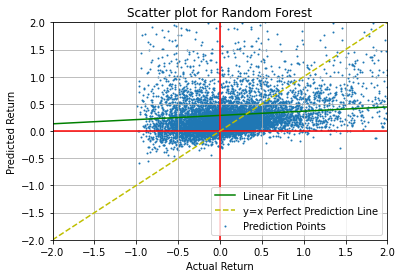

time: 344 ms (started: 2022-10-13 17:22:16 +08:00)


In [79]:
from sklearn.linear_model import LinearRegression

# Plotting scatter
plt.scatter(y_test.to_numpy(), y_pred, s=1)

# Drawing a best fit line
# Reshape the y_test and y_pred arrays
bestfit = LinearRegression().fit(y_test.to_numpy().reshape(-1, 1), y_pred.reshape(-1, 1))

# Specify any two points just to let the bestfit line predict
xx = [[-5],[5]]
yy = bestfit.predict(xx)
plt.plot(xx, yy, 'g')

# Plot formatting
plt.grid()
plt.axhline(y=0, color='r', label='_nolegend_')
plt.axvline(x=0, color='r', label='_nolegend_')
plt.xlabel('Actual Return')
plt.ylabel('Predicted Return')
plt.plot([-100,100], [-100,100], 'y--')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.title(f'Scatter plot for Random Forest')
plt.legend(['Linear Fit Line', 'y=x Perfect Prediction Line', 'Prediction Points'])

In [80]:
# Save for use in later notebook
pickle.dump(rf_tuned, open("rf_tuned.p", "wb" ))

time: 15 ms (started: 2022-10-13 17:36:50 +08:00)
